# Stable Diffusion Walkthrough

In [17]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
)


# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(mask_url).resize((img_height, img_width))

In [18]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Generating Images from Text

In [19]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)
pipe.enable_attention_slicing()

/home/seth/DiffusionModel/.venv/lib/python3.11/site-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1-base via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]An error occurred while trying to fetch /home/seth/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/1f758383196d38df1dfe523ddb1030f2bfab7741/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/seth/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/1f758383196d38df1dfe523ddb1030f2bfab7741/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components

100%|██████████| 35/35 [00:05<00:00,  6.22it/s]


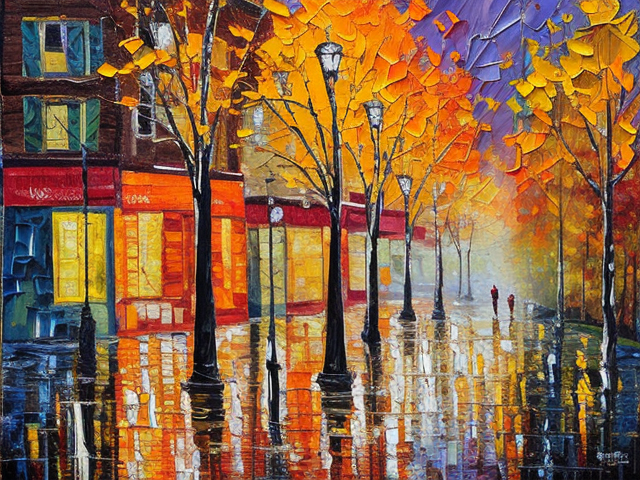

In [20]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",  # What to generate
    negative_prompt="Oversaturated, blurry, low quality",  # What NOT to generate
    height=480,
    width=640,  # Specify the image size
    guidance_scale=8,  # How strongly to follow the prompt
    num_inference_steps=35,  # How many steps to take
    generator=generator,  # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

Effects of increasing guidance scale:

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:04<00:00,  8.39it/s]


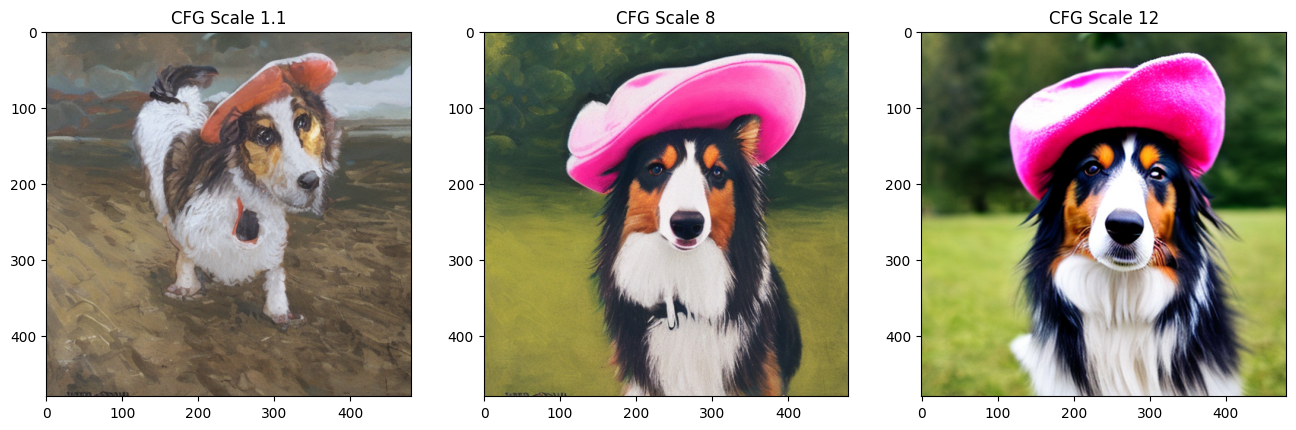

In [21]:
cfg_scales = [1.1, 8, 12]  # @param
prompt = "A collie with a pink hat"  # @param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(
        prompt,
        height=480,
        width=480,
        guidance_scale=cfg_scales[i],
        num_inference_steps=35,
        generator=torch.Generator(device=device).manual_seed(42),
    ).images[0]
    ax.imshow(im)
    ax.set_title(f"CFG Scale {cfg_scales[i]}")

### Pipeline Components

In [22]:
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


#### The VAE

The VAE is explained in the README file.

In [23]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device).half() * 2 - 1
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


#### Tokenizer and Text Encoder

The goal of the text encoder is to turn an input string (the prompt) into a numerical representation that can be fed to the UNet as conditioning.

In [24]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])["input_ids"]
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)["last_hidden_state"]
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [25]:
# Get the final text embeddings using the pipeline's encode_prompt function
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, True, "")
text_embeddings.shape

/home/seth/DiffusionModel/.venv/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


torch.Size([2, 77, 1024])

#### The UNet

The UNet takes a noisy input and predicts the noise, just like the UNets we've already worked on in `main.ipynb`. However, unlike previous examples, the input here is not an image, but instead a latent representation of an image.

In [26]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device).half()
text_embeddings = torch.randn(1, 77, 1024).to(device).half()

# Model prediction
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print("UNet output shape:", unet_output.shape)  # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


#### The Scheduler

The scheduler manages updating the noisy sample based on the model predictions. Default scheduler is PNDMScheduler, but you can use others as long as they are initialized with the same configuration.

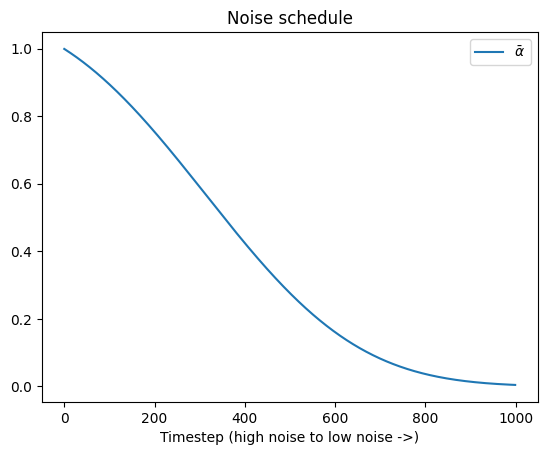

In [27]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r"$\bar{\alpha}$")
plt.xlabel("Timestep (high noise to low noise ->)")
plt.title("Noise schedule")
plt.legend()

Try out a different scheduler:

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}



100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


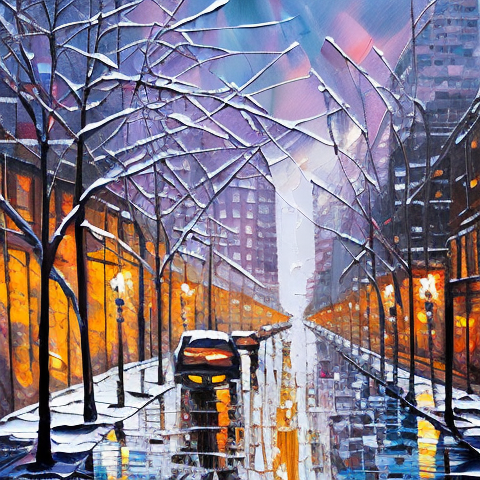

In [28]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print("Scheduler config:", pipe.scheduler)

# Generate an image with this new scheduler
pipe(
    prompt="Palette knife painting of an winter cityscape",
    height=480,
    width=480,
    generator=torch.Generator(device=device).manual_seed(42),
).images[0]

#### DIY Sampling Loop

Put all of the above components together to replicate the functionality of the pipeline.

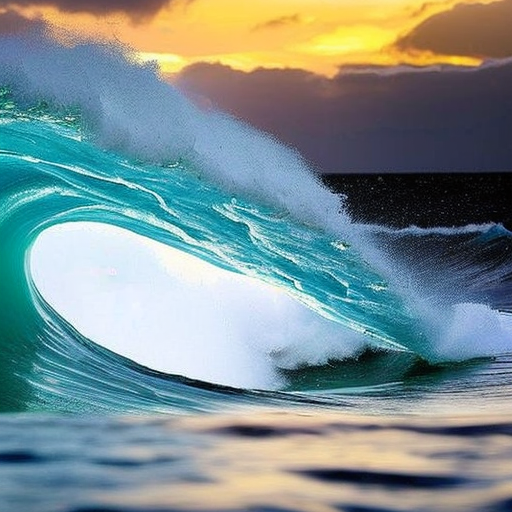

In [30]:
guidance_scale = 8  # @param
num_inference_steps = 30  # @param
prompt = "Beautiful picture of a wave breaking"  # @param
negative_prompt = "zoomed in, blurry, oversaturated, warped"  # @param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator).half()
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]